# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

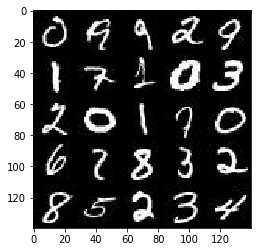

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

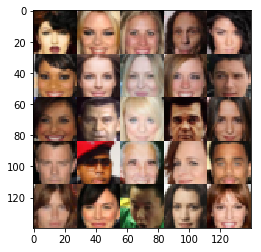

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [30]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    keep_prob = 0.65
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*layer1, layer1)
        
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(layer2, training=True)
        dropout2 = tf.layers.dropout(batch_norm2, rate=keep_prob, training=True)
        relu2 = tf.maximum(alpha*dropout2, dropout2)
        
        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(layer3, training=True)
        dropout3 = tf.layers.dropout(batch_norm3, rate=keep_prob, training=True)
        relu3 = tf.maximum(alpha*dropout3, dropout3)
        
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    
    reuse = not is_train
    keep_prob = 0.65
    alpha = 0.2
    
    with(tf.variable_scope('generator', reuse=reuse)):
        
        layer1 = tf.layers.dense(z, 4*4*512)
        layer1 = tf.reshape(layer1, (-1, 4, 4, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.layers.dropout(layer1, rate=keep_prob, training=is_train)
        layer1 = tf.maximum(alpha*layer1, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.layers.dropout(layer2, rate=keep_prob, training=is_train)
        layer2 = tf.maximum(alpha*layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.layers.dropout(layer3, rate=keep_prob, training=is_train)
        layer3 = tf.maximum(alpha*layer3, layer3)
        
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(logits, (28,28))
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()

    def get_vars_prefixed(variables, prefix):
        new_vars = []
        for variable in variables:
            if(variable.name[0:len(prefix)] == prefix):
                new_vars.append(variable)
        return new_vars

    g_vars = get_vars_prefixed(t_vars, 'generator')
    d_vars = get_vars_prefixed(t_vars, 'discriminator')

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    
    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver(var_list = g_vars)

    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every=50
    show_every=100
    
    if(data_image_mode == 'RGB'):
        input_channels = 3
    else:
        input_channels = 1
        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], input_channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, input_channels)
        
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Rescale images to be between -1 to 1
                batch_images = batch_images * 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                

                # Run optimizers
                with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                    _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                    _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, input_channels, data_image_mode)

    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 50... Discriminator Loss: 1.1376... Generator Loss: 1.9505
Epoch 1/2... Step 100... Discriminator Loss: 1.5331... Generator Loss: 1.5469


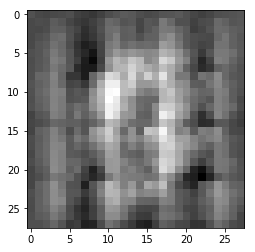

Epoch 1/2... Step 150... Discriminator Loss: 1.6219... Generator Loss: 1.0884
Epoch 1/2... Step 200... Discriminator Loss: 1.0930... Generator Loss: 1.7947


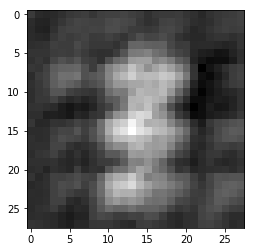

Epoch 1/2... Step 250... Discriminator Loss: 1.2719... Generator Loss: 1.0163
Epoch 1/2... Step 300... Discriminator Loss: 1.5462... Generator Loss: 1.7030


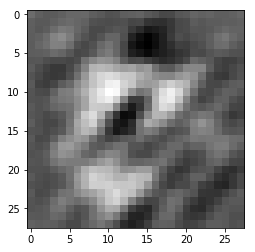

Epoch 1/2... Step 350... Discriminator Loss: 1.3587... Generator Loss: 1.2906
Epoch 1/2... Step 400... Discriminator Loss: 0.9886... Generator Loss: 1.4622


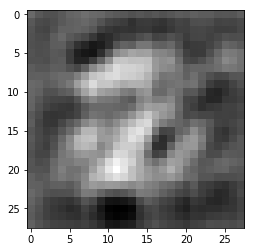

Epoch 1/2... Step 450... Discriminator Loss: 1.1697... Generator Loss: 1.2633
Epoch 1/2... Step 500... Discriminator Loss: 1.2004... Generator Loss: 1.8258


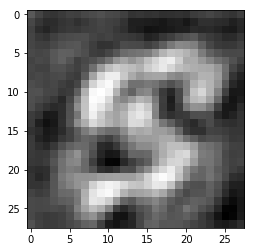

Epoch 1/2... Step 550... Discriminator Loss: 0.7412... Generator Loss: 2.2410
Epoch 1/2... Step 600... Discriminator Loss: 1.0358... Generator Loss: 1.2399


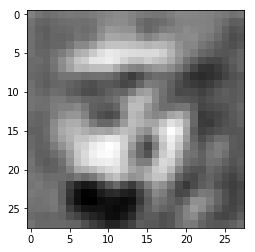

Epoch 1/2... Step 650... Discriminator Loss: 1.0934... Generator Loss: 1.4056
Epoch 1/2... Step 700... Discriminator Loss: 1.1029... Generator Loss: 1.5760


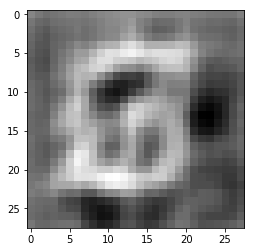

Epoch 1/2... Step 750... Discriminator Loss: 0.9035... Generator Loss: 1.7570
Epoch 1/2... Step 800... Discriminator Loss: 1.0501... Generator Loss: 1.5609


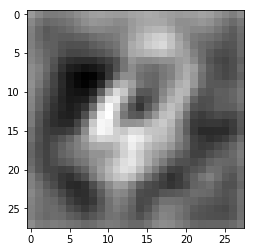

Epoch 1/2... Step 850... Discriminator Loss: 1.0169... Generator Loss: 1.7926
Epoch 1/2... Step 900... Discriminator Loss: 1.2777... Generator Loss: 1.0405


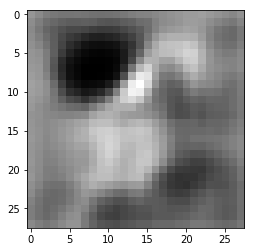

Epoch 1/2... Step 950... Discriminator Loss: 1.4387... Generator Loss: 2.1760
Epoch 1/2... Step 1000... Discriminator Loss: 1.1426... Generator Loss: 1.0749


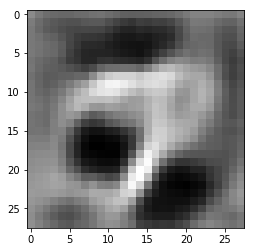

Epoch 1/2... Step 1050... Discriminator Loss: 0.9450... Generator Loss: 1.1780
Epoch 1/2... Step 1100... Discriminator Loss: 1.1559... Generator Loss: 1.9995


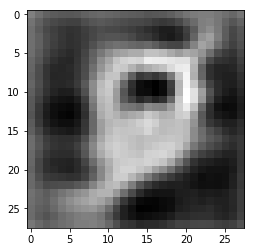

Epoch 1/2... Step 1150... Discriminator Loss: 1.0410... Generator Loss: 1.5960
Epoch 1/2... Step 1200... Discriminator Loss: 1.0263... Generator Loss: 2.1801


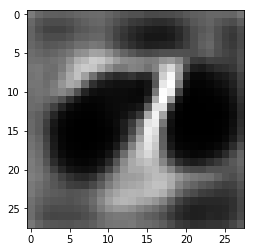

Epoch 1/2... Step 1250... Discriminator Loss: 0.9669... Generator Loss: 0.7819
Epoch 1/2... Step 1300... Discriminator Loss: 1.0699... Generator Loss: 1.6238


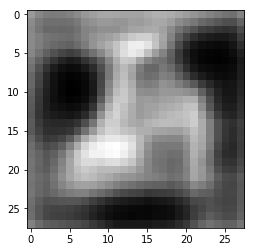

Epoch 1/2... Step 1350... Discriminator Loss: 0.9943... Generator Loss: 1.5071
Epoch 1/2... Step 1400... Discriminator Loss: 0.7943... Generator Loss: 1.5047


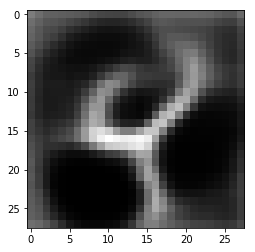

Epoch 1/2... Step 1450... Discriminator Loss: 1.0656... Generator Loss: 0.9872
Epoch 1/2... Step 1500... Discriminator Loss: 1.1080... Generator Loss: 2.2546


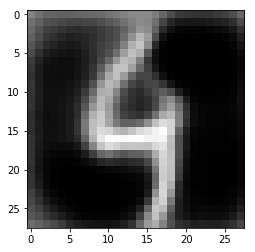

Epoch 1/2... Step 1550... Discriminator Loss: 0.9463... Generator Loss: 1.3464
Epoch 1/2... Step 1600... Discriminator Loss: 0.8958... Generator Loss: 1.5202


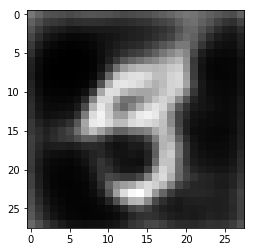

Epoch 1/2... Step 1650... Discriminator Loss: 0.9746... Generator Loss: 2.4519
Epoch 1/2... Step 1700... Discriminator Loss: 0.9104... Generator Loss: 1.2541


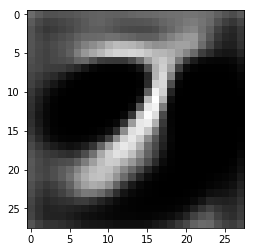

Epoch 1/2... Step 1750... Discriminator Loss: 0.9508... Generator Loss: 2.0308
Epoch 1/2... Step 1800... Discriminator Loss: 1.1273... Generator Loss: 1.0565


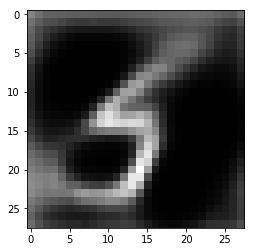

Epoch 1/2... Step 1850... Discriminator Loss: 0.9964... Generator Loss: 1.0967
Epoch 2/2... Step 1900... Discriminator Loss: 1.0079... Generator Loss: 2.0546


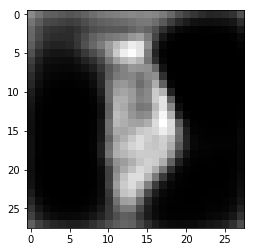

Epoch 2/2... Step 1950... Discriminator Loss: 0.7645... Generator Loss: 1.6255
Epoch 2/2... Step 2000... Discriminator Loss: 0.9250... Generator Loss: 1.3987


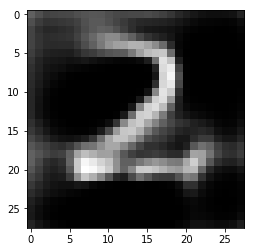

Epoch 2/2... Step 2050... Discriminator Loss: 0.7978... Generator Loss: 1.3235
Epoch 2/2... Step 2100... Discriminator Loss: 0.8404... Generator Loss: 1.6975


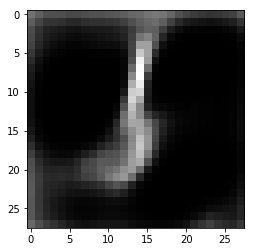

Epoch 2/2... Step 2150... Discriminator Loss: 0.7896... Generator Loss: 1.7992
Epoch 2/2... Step 2200... Discriminator Loss: 1.1142... Generator Loss: 1.5999


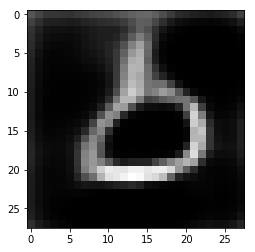

Epoch 2/2... Step 2250... Discriminator Loss: 0.7748... Generator Loss: 2.0338
Epoch 2/2... Step 2300... Discriminator Loss: 0.7641... Generator Loss: 2.1843


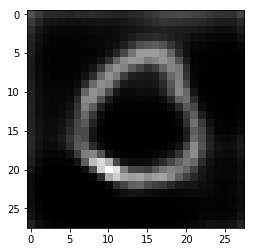

Epoch 2/2... Step 2350... Discriminator Loss: 0.8320... Generator Loss: 1.8654
Epoch 2/2... Step 2400... Discriminator Loss: 0.9464... Generator Loss: 1.1976


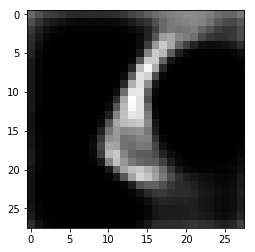

Epoch 2/2... Step 2450... Discriminator Loss: 1.3548... Generator Loss: 0.9110
Epoch 2/2... Step 2500... Discriminator Loss: 0.6792... Generator Loss: 1.9329


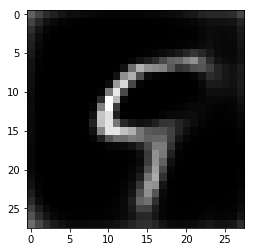

Epoch 2/2... Step 2550... Discriminator Loss: 0.6242... Generator Loss: 1.9716
Epoch 2/2... Step 2600... Discriminator Loss: 0.6733... Generator Loss: 1.9323


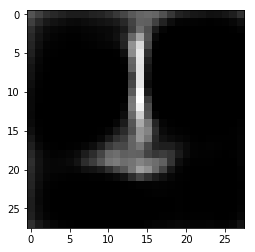

Epoch 2/2... Step 2650... Discriminator Loss: 0.9017... Generator Loss: 3.1657
Epoch 2/2... Step 2700... Discriminator Loss: 0.8395... Generator Loss: 2.1945


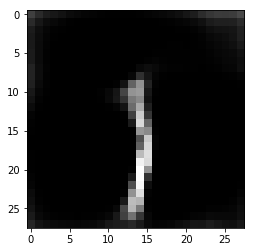

Epoch 2/2... Step 2750... Discriminator Loss: 0.8551... Generator Loss: 2.4436
Epoch 2/2... Step 2800... Discriminator Loss: 0.4628... Generator Loss: 3.3671


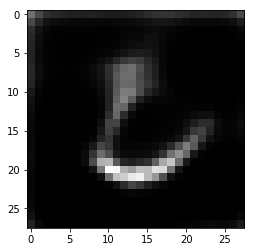

Epoch 2/2... Step 2850... Discriminator Loss: 0.6826... Generator Loss: 2.9952
Epoch 2/2... Step 2900... Discriminator Loss: 0.7880... Generator Loss: 1.3546


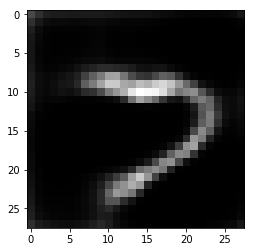

Epoch 2/2... Step 2950... Discriminator Loss: 0.7578... Generator Loss: 3.3972
Epoch 2/2... Step 3000... Discriminator Loss: 0.7721... Generator Loss: 0.9246


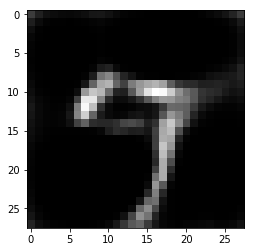

Epoch 2/2... Step 3050... Discriminator Loss: 0.6769... Generator Loss: 2.4529
Epoch 2/2... Step 3100... Discriminator Loss: 0.8537... Generator Loss: 1.9401


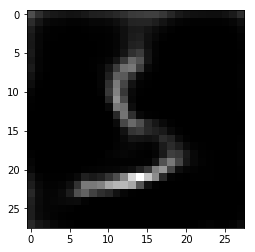

Epoch 2/2... Step 3150... Discriminator Loss: 0.7803... Generator Loss: 1.3352
Epoch 2/2... Step 3200... Discriminator Loss: 0.7586... Generator Loss: 3.2613


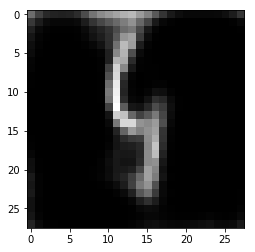

Epoch 2/2... Step 3250... Discriminator Loss: 0.6799... Generator Loss: 2.5674
Epoch 2/2... Step 3300... Discriminator Loss: 0.5748... Generator Loss: 3.1609


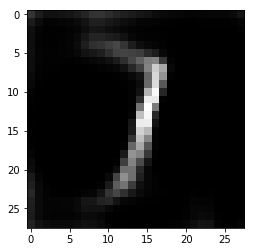

Epoch 2/2... Step 3350... Discriminator Loss: 0.8794... Generator Loss: 4.0982
Epoch 2/2... Step 3400... Discriminator Loss: 0.5909... Generator Loss: 2.4489


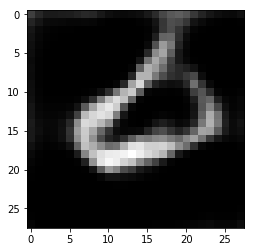

Epoch 2/2... Step 3450... Discriminator Loss: 0.6701... Generator Loss: 1.6213
Epoch 2/2... Step 3500... Discriminator Loss: 0.4045... Generator Loss: 2.2882


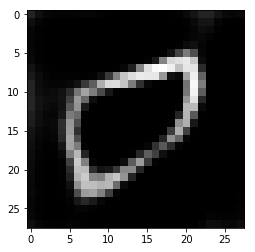

Epoch 2/2... Step 3550... Discriminator Loss: 0.2613... Generator Loss: 2.5221
Epoch 2/2... Step 3600... Discriminator Loss: 0.3631... Generator Loss: 2.5488


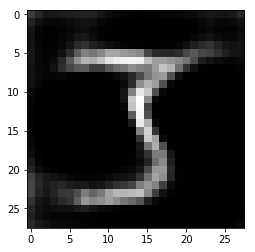

Epoch 2/2... Step 3650... Discriminator Loss: 0.6833... Generator Loss: 1.6321
Epoch 2/2... Step 3700... Discriminator Loss: 0.6038... Generator Loss: 3.3615


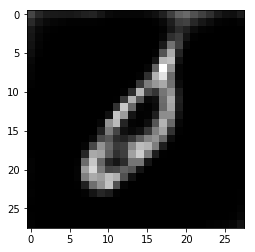

Epoch 2/2... Step 3750... Discriminator Loss: 0.3902... Generator Loss: 2.8622


In [32]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 50... Discriminator Loss: 1.1605... Generator Loss: 1.2937
Epoch 1/1... Step 100... Discriminator Loss: 0.5665... Generator Loss: 2.0303


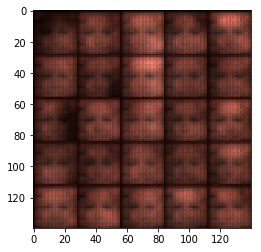

Epoch 1/1... Step 150... Discriminator Loss: 1.3047... Generator Loss: 1.7244
Epoch 1/1... Step 200... Discriminator Loss: 1.1127... Generator Loss: 1.8219


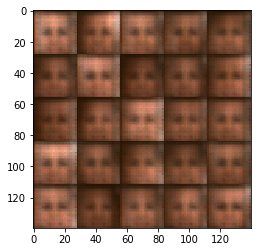

Epoch 1/1... Step 250... Discriminator Loss: 1.2449... Generator Loss: 1.2981
Epoch 1/1... Step 300... Discriminator Loss: 1.1479... Generator Loss: 1.1892


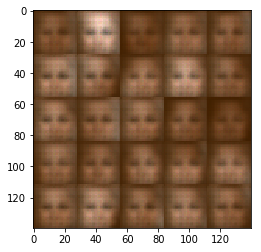

Epoch 1/1... Step 350... Discriminator Loss: 1.1914... Generator Loss: 2.1901
Epoch 1/1... Step 400... Discriminator Loss: 1.4442... Generator Loss: 0.9463


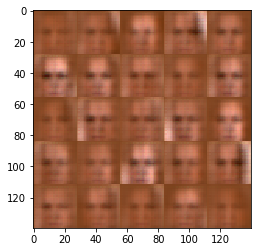

Epoch 1/1... Step 450... Discriminator Loss: 1.2604... Generator Loss: 1.3916
Epoch 1/1... Step 500... Discriminator Loss: 0.9630... Generator Loss: 1.3579


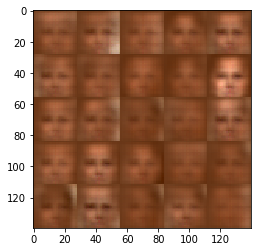

Epoch 1/1... Step 550... Discriminator Loss: 1.3433... Generator Loss: 1.0382
Epoch 1/1... Step 600... Discriminator Loss: 1.4063... Generator Loss: 1.2484


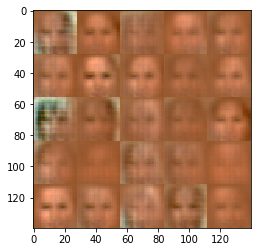

Epoch 1/1... Step 650... Discriminator Loss: 0.9921... Generator Loss: 1.2412
Epoch 1/1... Step 700... Discriminator Loss: 1.3194... Generator Loss: 1.1494


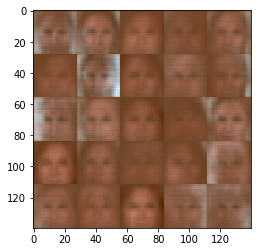

Epoch 1/1... Step 750... Discriminator Loss: 1.3545... Generator Loss: 0.9706
Epoch 1/1... Step 800... Discriminator Loss: 1.2858... Generator Loss: 1.3240


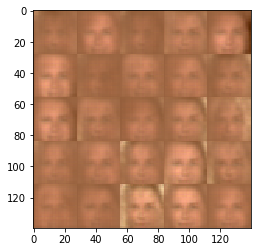

Epoch 1/1... Step 850... Discriminator Loss: 1.1673... Generator Loss: 1.0261
Epoch 1/1... Step 900... Discriminator Loss: 1.4885... Generator Loss: 1.0699


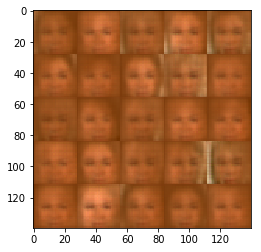

Epoch 1/1... Step 950... Discriminator Loss: 0.8195... Generator Loss: 1.1928
Epoch 1/1... Step 1000... Discriminator Loss: 1.3576... Generator Loss: 0.8339


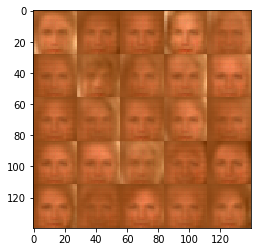

Epoch 1/1... Step 1050... Discriminator Loss: 1.3125... Generator Loss: 1.1847
Epoch 1/1... Step 1100... Discriminator Loss: 1.3532... Generator Loss: 0.7107


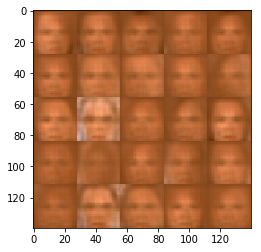

Epoch 1/1... Step 1150... Discriminator Loss: 1.3691... Generator Loss: 0.8758
Epoch 1/1... Step 1200... Discriminator Loss: 1.2340... Generator Loss: 0.7890


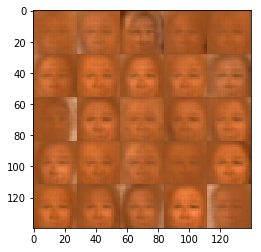

Epoch 1/1... Step 1250... Discriminator Loss: 1.4907... Generator Loss: 0.7622
Epoch 1/1... Step 1300... Discriminator Loss: 1.2806... Generator Loss: 0.9085


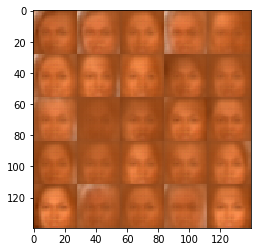

Epoch 1/1... Step 1350... Discriminator Loss: 1.5429... Generator Loss: 1.0838
Epoch 1/1... Step 1400... Discriminator Loss: 1.4072... Generator Loss: 1.1978


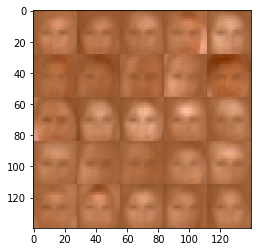

Epoch 1/1... Step 1450... Discriminator Loss: 1.4240... Generator Loss: 1.2729
Epoch 1/1... Step 1500... Discriminator Loss: 1.5247... Generator Loss: 0.6504


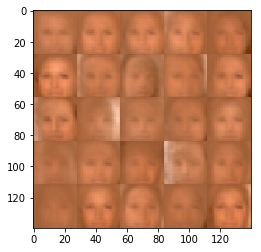

Epoch 1/1... Step 1550... Discriminator Loss: 1.4151... Generator Loss: 0.6059
Epoch 1/1... Step 1600... Discriminator Loss: 1.2214... Generator Loss: 1.1957


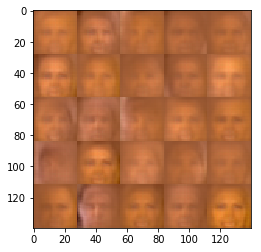

Epoch 1/1... Step 1650... Discriminator Loss: 1.1288... Generator Loss: 1.0025
Epoch 1/1... Step 1700... Discriminator Loss: 1.3925... Generator Loss: 1.0894


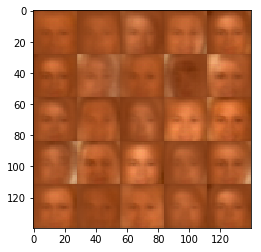

Epoch 1/1... Step 1750... Discriminator Loss: 1.4736... Generator Loss: 0.7687
Epoch 1/1... Step 1800... Discriminator Loss: 1.4869... Generator Loss: 0.9477


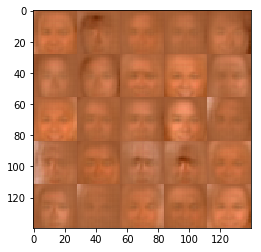

Epoch 1/1... Step 1850... Discriminator Loss: 1.1771... Generator Loss: 1.1155
Epoch 1/1... Step 1900... Discriminator Loss: 1.4781... Generator Loss: 0.9151


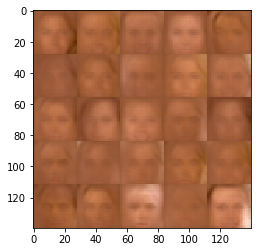

Epoch 1/1... Step 1950... Discriminator Loss: 1.4883... Generator Loss: 0.7465
Epoch 1/1... Step 2000... Discriminator Loss: 1.3533... Generator Loss: 1.1142


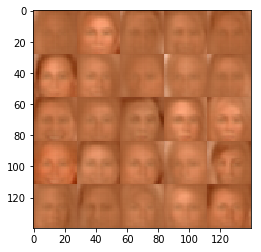

Epoch 1/1... Step 2050... Discriminator Loss: 1.3374... Generator Loss: 0.9082
Epoch 1/1... Step 2100... Discriminator Loss: 1.4897... Generator Loss: 0.7793


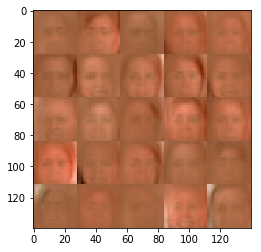

Epoch 1/1... Step 2150... Discriminator Loss: 1.4412... Generator Loss: 0.8460
Epoch 1/1... Step 2200... Discriminator Loss: 1.1916... Generator Loss: 0.9233


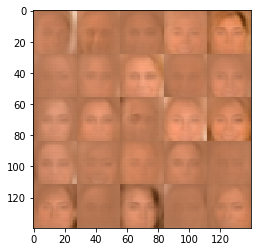

Epoch 1/1... Step 2250... Discriminator Loss: 1.5154... Generator Loss: 0.8547
Epoch 1/1... Step 2300... Discriminator Loss: 1.4895... Generator Loss: 0.8985


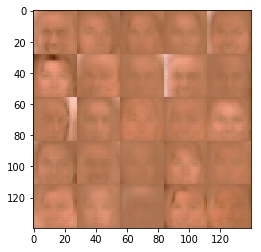

Epoch 1/1... Step 2350... Discriminator Loss: 1.4433... Generator Loss: 0.8117
Epoch 1/1... Step 2400... Discriminator Loss: 1.2656... Generator Loss: 1.0463


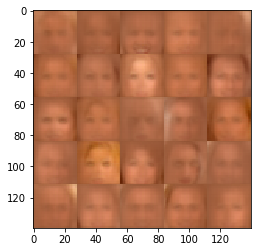

Epoch 1/1... Step 2450... Discriminator Loss: 1.3348... Generator Loss: 0.9938
Epoch 1/1... Step 2500... Discriminator Loss: 1.2059... Generator Loss: 0.7257


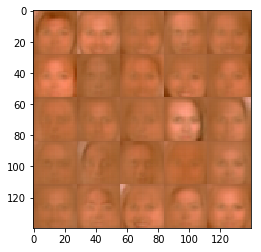

Epoch 1/1... Step 2550... Discriminator Loss: 1.2728... Generator Loss: 0.9713
Epoch 1/1... Step 2600... Discriminator Loss: 1.4605... Generator Loss: 0.7876


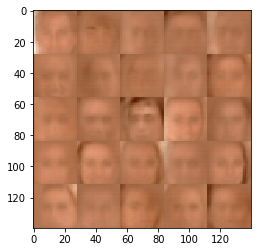

Epoch 1/1... Step 2650... Discriminator Loss: 1.4576... Generator Loss: 0.6899
Epoch 1/1... Step 2700... Discriminator Loss: 1.5686... Generator Loss: 0.7377


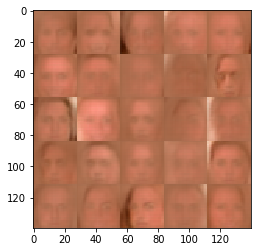

Epoch 1/1... Step 2750... Discriminator Loss: 1.4106... Generator Loss: 0.9610
Epoch 1/1... Step 2800... Discriminator Loss: 1.3060... Generator Loss: 0.9118


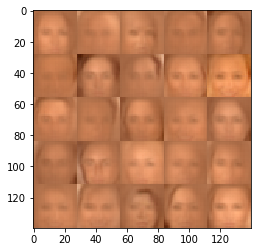

Epoch 1/1... Step 2850... Discriminator Loss: 1.3864... Generator Loss: 0.6961
Epoch 1/1... Step 2900... Discriminator Loss: 1.1400... Generator Loss: 0.8110


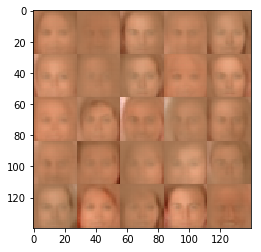

Epoch 1/1... Step 2950... Discriminator Loss: 1.3708... Generator Loss: 0.7077
Epoch 1/1... Step 3000... Discriminator Loss: 1.2918... Generator Loss: 0.7178


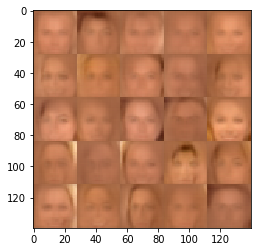

Epoch 1/1... Step 3050... Discriminator Loss: 1.3323... Generator Loss: 1.0218
Epoch 1/1... Step 3100... Discriminator Loss: 1.2947... Generator Loss: 0.8109


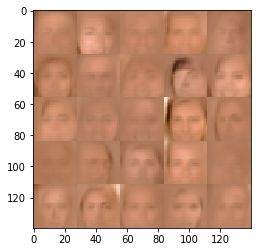

Epoch 1/1... Step 3150... Discriminator Loss: 1.3686... Generator Loss: 0.6921
Epoch 1/1... Step 3200... Discriminator Loss: 1.4475... Generator Loss: 0.7518


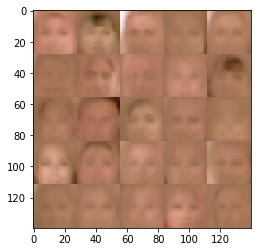

Epoch 1/1... Step 3250... Discriminator Loss: 1.3035... Generator Loss: 0.8337
Epoch 1/1... Step 3300... Discriminator Loss: 1.3472... Generator Loss: 0.7981


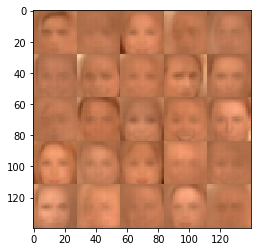

Epoch 1/1... Step 3350... Discriminator Loss: 1.3332... Generator Loss: 0.9393
Epoch 1/1... Step 3400... Discriminator Loss: 1.4547... Generator Loss: 0.9332


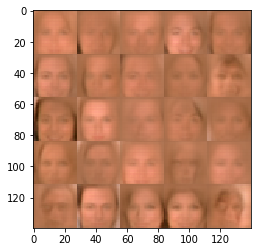

Epoch 1/1... Step 3450... Discriminator Loss: 1.5003... Generator Loss: 0.9280
Epoch 1/1... Step 3500... Discriminator Loss: 1.3983... Generator Loss: 0.8221


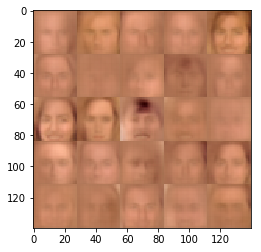

Epoch 1/1... Step 3550... Discriminator Loss: 1.2727... Generator Loss: 0.7421
Epoch 1/1... Step 3600... Discriminator Loss: 1.3485... Generator Loss: 0.7221


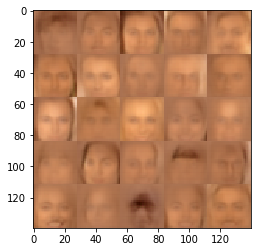

Epoch 1/1... Step 3650... Discriminator Loss: 1.4446... Generator Loss: 0.9277
Epoch 1/1... Step 3700... Discriminator Loss: 1.4213... Generator Loss: 0.7082


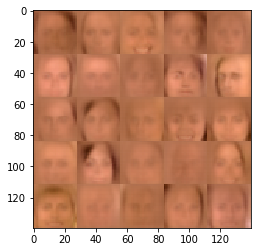

Epoch 1/1... Step 3750... Discriminator Loss: 1.4102... Generator Loss: 0.6785
Epoch 1/1... Step 3800... Discriminator Loss: 1.1804... Generator Loss: 0.8251


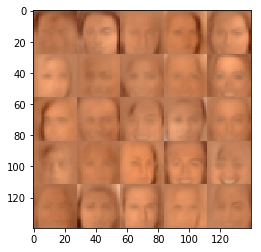

Epoch 1/1... Step 3850... Discriminator Loss: 1.3185... Generator Loss: 0.8438
Epoch 1/1... Step 3900... Discriminator Loss: 1.3445... Generator Loss: 0.7304


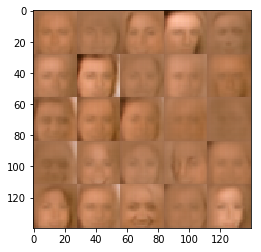

Epoch 1/1... Step 3950... Discriminator Loss: 1.4145... Generator Loss: 0.7367
Epoch 1/1... Step 4000... Discriminator Loss: 1.2456... Generator Loss: 0.8899


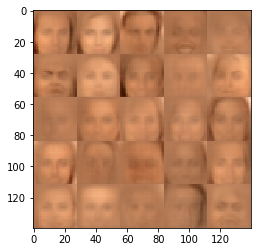

Epoch 1/1... Step 4050... Discriminator Loss: 1.3435... Generator Loss: 0.6785
Epoch 1/1... Step 4100... Discriminator Loss: 1.3592... Generator Loss: 0.7759


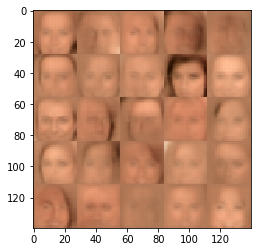

Epoch 1/1... Step 4150... Discriminator Loss: 1.2666... Generator Loss: 0.8951
Epoch 1/1... Step 4200... Discriminator Loss: 1.2630... Generator Loss: 0.9447


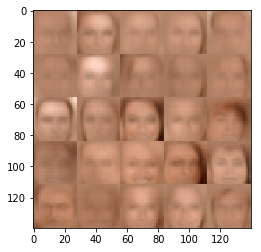

Epoch 1/1... Step 4250... Discriminator Loss: 1.3125... Generator Loss: 0.7273
Epoch 1/1... Step 4300... Discriminator Loss: 1.4713... Generator Loss: 0.7070


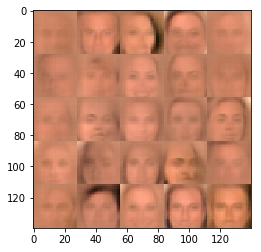

Epoch 1/1... Step 4350... Discriminator Loss: 1.2459... Generator Loss: 0.9511
Epoch 1/1... Step 4400... Discriminator Loss: 1.2986... Generator Loss: 0.8753


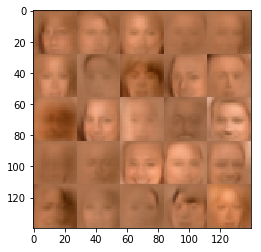

Epoch 1/1... Step 4450... Discriminator Loss: 1.3715... Generator Loss: 0.8224
Epoch 1/1... Step 4500... Discriminator Loss: 1.1693... Generator Loss: 1.0583


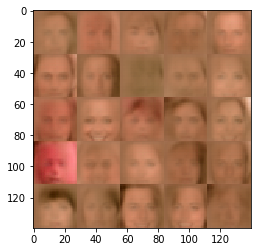

Epoch 1/1... Step 4550... Discriminator Loss: 1.3403... Generator Loss: 0.7572
Epoch 1/1... Step 4600... Discriminator Loss: 1.4177... Generator Loss: 0.7438


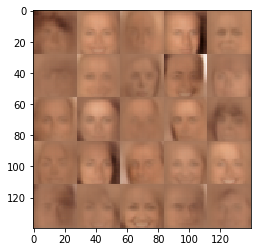

Epoch 1/1... Step 4650... Discriminator Loss: 1.3983... Generator Loss: 0.9256
Epoch 1/1... Step 4700... Discriminator Loss: 1.2303... Generator Loss: 0.7781


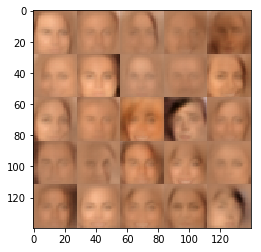

Epoch 1/1... Step 4750... Discriminator Loss: 1.4789... Generator Loss: 0.9062
Epoch 1/1... Step 4800... Discriminator Loss: 1.3691... Generator Loss: 0.7869


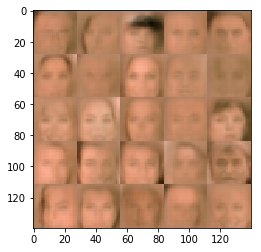

Epoch 1/1... Step 4850... Discriminator Loss: 1.4991... Generator Loss: 0.9568
Epoch 1/1... Step 4900... Discriminator Loss: 1.2079... Generator Loss: 0.9177


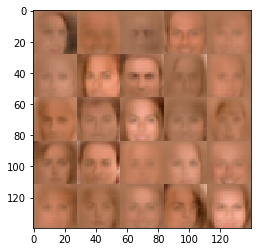

Epoch 1/1... Step 4950... Discriminator Loss: 1.3606... Generator Loss: 0.7901
Epoch 1/1... Step 5000... Discriminator Loss: 1.3658... Generator Loss: 0.8112


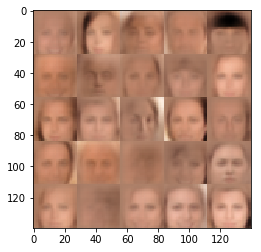

Epoch 1/1... Step 5050... Discriminator Loss: 1.2987... Generator Loss: 0.7849
Epoch 1/1... Step 5100... Discriminator Loss: 1.1524... Generator Loss: 0.9942


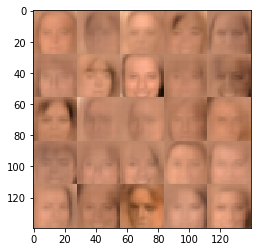

Epoch 1/1... Step 5150... Discriminator Loss: 1.2317... Generator Loss: 0.7848
Epoch 1/1... Step 5200... Discriminator Loss: 1.4473... Generator Loss: 0.8618


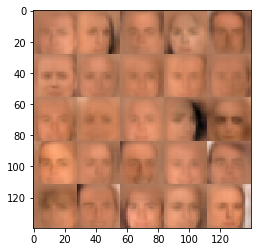

Epoch 1/1... Step 5250... Discriminator Loss: 1.2761... Generator Loss: 1.0119
Epoch 1/1... Step 5300... Discriminator Loss: 1.2944... Generator Loss: 0.8056


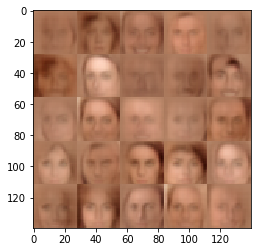

Epoch 1/1... Step 5350... Discriminator Loss: 1.3459... Generator Loss: 0.8498
Epoch 1/1... Step 5400... Discriminator Loss: 1.1893... Generator Loss: 0.7471


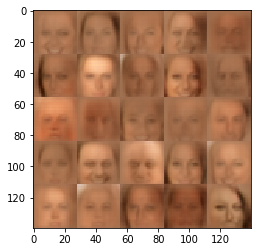

Epoch 1/1... Step 5450... Discriminator Loss: 1.3096... Generator Loss: 0.8787
Epoch 1/1... Step 5500... Discriminator Loss: 1.0822... Generator Loss: 0.9089


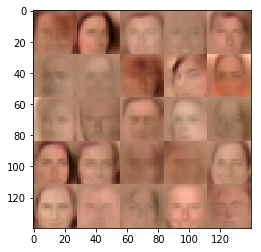

Epoch 1/1... Step 5550... Discriminator Loss: 1.3055... Generator Loss: 0.7400
Epoch 1/1... Step 5600... Discriminator Loss: 1.2769... Generator Loss: 0.7039


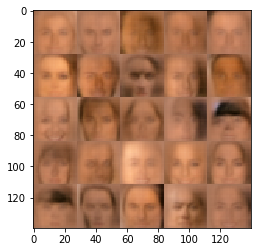

Epoch 1/1... Step 5650... Discriminator Loss: 1.3352... Generator Loss: 0.8679


KeyboardInterrupt: 

In [35]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.